In [1]:
##
#JemelyR
#24W, cs83
#PA1
#
#imagefilter
##

import numpy as np

def myImageFilter(img0, h):
    print("running image filter")
#     print(h)
    imgH, imgW = img0.shape #height and width of image
    fH, fW = h.shape #height and width of filter

    #padding
    pH = fH // 2 #padding for height
    pW = fW // 2 #padding for width

    #padding image
    padded = np.pad(img0, ((pH, pH), (pW, pW)), mode='edge')

    img1 = np.zeros_like(img0)
    #reference for np.zeros_like: https://numpy.org/doc/stable/reference/generated/numpy.zeros_like.html
    

    #convolutiopn
    for i in range(fH):
        for j in range(fW):
            img1 += h[i, j] * padded[i:i + imgH, j:j + imgW]

    return img1




In [2]:
##
#JemelyR
#24W, cs83
#PA1
#
#edge filter
##

import numpy as np
from scipy import signal    

def myEdgeFilter(img0, sigma):

    #kernel to smooth
    hSize = int(2 * np.ceil(3 * sigma) + 1)
    
    kernel = signal.gaussian(hSize, sigma).reshape(hSize, 1)#gaussian kernel
    kernel = np.dot(kernel, kernel.T)

    #smoothing with previous function
    smoothed = myImageFilter(img0, kernel)
    
    #sobel filters
    sobx = np.array([[-1, 0, 1], 
                        [-2, 0, 2], 
                        [-1, 0, 1]])
    
    soby = np.array([[1, 2, 1], 
                        [0, 0, 0], 
                        [-1, -2, -1]])

      
    #image gradient y&x
    imgx = myImageFilter(smoothed, sobx)
    imgy = myImageFilter(smoothed, soby)
    
    
    magnitude = np.sqrt(imgx**2 + imgy**2) #gradient magnitude
    
    edge_angle = np.arctan2(imgy, imgx) * 180 / np.pi #edge angle
    edge_angle[edge_angle < 0] += 180

    rounded_angle = np.round(edge_angle / 45) * 45
    
    #map 180 back to 0
    rounded_angle[rounded_angle == 180] = 0  

    img1 = np.zeros_like(magnitude)
    
    #supression
    for i in range(1, magnitude.shape[0] - 1):
        for j in range(1, magnitude.shape[1] - 1):
            # neighbouring pixels
            angle = rounded_angle[i, j] #gradient angle
            if angle == 0 or angle == 180:
                n1 = magnitude[i, j+1] #first neighbor
                n2 = magnitude[i, j-1] #second neighbor
            elif angle == 45:
                n1 = magnitude[i+1, j-1]
                n2 = magnitude[i-1, j+1]
            elif angle == 90:
                n1 = magnitude[i+1, j]
                n2 = magnitude[i-1, j]
            elif angle == 135:
                n1 = magnitude[i-1, j-1]
                n2 = magnitude[i+1, j+1]

            # Suppress non-maximum edges
            if magnitude[i, j] >= n1 and magnitude[i, j] >= n2:
                img1[i, j] = magnitude[i, j]

    return img1

In [3]:
##
#JemelyR
#24W, cs83
#PA1
#
#hough tranform
##

import numpy as np


def myHoughTransform(Im, rhoRes, thetaRes):
    imgH, imgW = Im.shape #Im height and width
    
    M = np.sqrt(imgH**2 + imgW**2)#needs to be large enought to accomidate possible lines
    rhoS = np.arange(0, M, rhoRes)
    thetaS = np.arange(0, 2*np.pi, thetaRes)
    
    #contains "votes"
    img_hough = np.zeros((len(rhoS), len(thetaS)))

    #edge indices
    edges = np.transpose(np.nonzero(Im))

    #rho for each edge index and theta value
    cos = np.cos(thetaS)
    sin = np.sin(thetaS)
    rho = np.rint(np.matmul(edges, np.array([sin, cos]))).astype(int)
    #rint ref:https://numpy.org/doc/stable/reference/generated/numpy.rint.html

    #hough space
    img_hough, rhoScale, thetaScale = np.histogram2d(rho.ravel(), np.tile(thetaS, rho.shape[0]),
                                           bins=[rhoS,thetaS], range=[[0, M],[0, 2*np.pi]])
    #histogram reference: https://numpy.org/doc/stable/reference/generated/numpy.histogram.html

    return img_hough, rhoScale, thetaScale

    
# plt.imshow(img_hough, cmap='ah', extent=[thetaScale.min(), thetaScale.max(), rhoScale.min(), rhoScale.max()],
#            aspect='auto', origin='lower')
# plt.xlabel('Theta (radians)')
# plt.ylabel('Rho (pixels)')
# plt.title('Hough Transform')
# plt.colorbar(label='Votes')
# plt.show()
    

In [4]:
##
#JemelyR
#24W, cs83
#PA1
#
#hough lines
##

import numpy as np
import cv2

def myHoughLines(H, nLines):

    H = H.astype(np.float32)

    kernel_size = (3, 3)  # kernel size for dilation
    kernel = np.ones(kernel_size, np.float32)
    
    #supress nonmaximal cells
    dilated = cv2.dilate(H, kernel)

    H[H != dilated] = 0
#     H = np.where(dilated > 0, 0, dilated)

    #for rho and theta parameters
    rhos = np.zeros(nLines, dtype=int)
    thetas = np.zeros(nLines, dtype=int)

    #peaks
    for i in range(nLines):
        maX = np.argmax(H) #nLines maxes 
        #argmax ref: https://numpy.org/doc/stable/reference/generated/numpy.argmax.html]
        rhoMax, thetaMax = np.unravel_index(maX, H.shape)
        rhos[i] = rhoMax
        thetas[i] = thetaMax
        H[rhoMax, thetaMax] = 0

    return rhos, thetas



In [5]:
import cv2
import numpy as np
import os

from myEdgeFilter import myEdgeFilter
from myHoughLines import myHoughLines
from myHoughTransform import myHoughTransform

datadir    = '../data'      # the directory containing the images
resultsdir = '../results'   # the directory for dumping results

# parameters
sigma     = 3
threshold = 0.975
rhoRes    = 2
thetaRes  = np.pi / 90
nLines    = 15
# end of parameters

for file in os.listdir(datadir):
    if file.endswith('.jpg'):

        file = os.path.splitext(file)[0]
        
        # read in images
        img = cv2.imread('%s/%s.jpg' % (datadir, file))
        
        if (img.ndim == 3):
            img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        
        img = np.float32(img) / 255
        
        # actual Hough line code function calls
        img_edge = myEdgeFilter(img, sigma)
        img_threshold = np.float32(img_edge > threshold)
        [img_hough, rhoScale, thetaScale] = myHoughTransform(img_threshold, \
                                                             rhoRes, thetaRes)
        [rhos, thetas] = myHoughLines(img_hough, nLines)

        lines = cv2.HoughLinesP(np.uint8(255 * img_threshold), rhoRes, thetaRes, \
                                50, minLineLength = 20, maxLineGap = 5)

        # everything below here just saves the outputs to files
        fname = '%s/%s_01edge.png' % (resultsdir, file)
        cv2.imwrite(fname, 255 * np.sqrt(img_edge / img_edge.max()))
        
        fname = '%s/%s_02threshold.png' % (resultsdir, file)
        cv2.imwrite(fname, 255 * img_threshold)
        
        fname = '%s/%s_03hough.png' % (resultsdir, file)
        cv2.imwrite(fname, 255 * img_hough / img_hough.max())
        
        fname = '%s/%s_04lines.png' % (resultsdir, file)
        img_lines = np.dstack([img,img,img])

        # display line results from myHoughLines function in red
        for k in np.arange(nLines): 
            a = np.cos(thetaScale[thetas[k]])
            b = np.sin(thetaScale[thetas[k]])
            
            x0 = a*rhoScale[rhos[k]]
            y0 = b*rhoScale[rhos[k]]
            
            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))
            
            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))
            
            cv2.line(img_lines,(x1,y1),(x2,y2),(0,0,255),1)
        
        # display line segment results from cv2.HoughLinesP in green
        for line in lines:
            coords = line[0]
            cv2.line(img_lines, (coords[0], coords[1]), (coords[2], coords[3]), \
                     (0, 255, 0), 1)

        cv2.imwrite(fname, 255 * img_lines)


print("done")



running image filter
running image filter
running image filter
running image filter
running image filter
running image filter
running image filter
running image filter
running image filter
running image filter
running image filter
running image filter
running image filter
running image filter
running image filter
running image filter
running image filter
running image filter
running image filter
running image filter
running image filter
running image filter
running image filter
running image filter
running image filter
running image filter
running image filter
running image filter
running image filter
running image filter
done


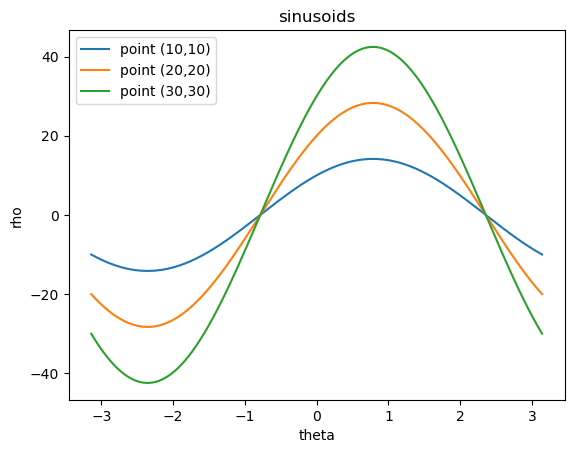

In [6]:
##
#jemelyR
#For theory question 4
#


import numpy as np
import matplotlib.pyplot as plt

#given points
points = [(10, 10), (20, 20), (30, 30)]

#theta range
theta = np.linspace(-np.pi, np.pi, 400)

fig, ax = plt.subplots()
ax.set_title("sinusoids")
ax.set_xlabel("theta")
ax.set_ylabel("rho")

#plot the points
rho = 10 * np.cos(theta) + 10 * np.sin(theta)
ax.plot(theta, rho, label=f'point (10,10)')

rho = 20 * np.cos(theta) + 20 * np.sin(theta)
ax.plot(theta, rho, label=f'point (20,20)')

rho = 30 * np.cos(theta) + 30 * np.sin(theta)
ax.plot(theta, rho, label=f'point (30,30)')

#show
ax.legend()
plt.show()
